In [1]:
import os
import glob
import numpy as np
from diskKLIP import diskDuster
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# path here
root = os.getcwd()
hadata_latest = root+'/../forwardModel/data/18May15/Ha'
offdata_latest = root+'/../forwardModel/data/18May15/Cont'

In [3]:
ann = 1 
mov = 60
KLs = [5]

In [4]:
# ha
ha = diskDuster(hadata_latest, 'test1', 'output', klipparams=[ann, mov, KLs])
ha.run_KLIP()
ha.get_result()

reading data, num files:  153
Total number of tasks for KLIP processing is 1
Begin processing of wv 0.656 with index 0
Aligning and scaling imgs
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Closing threadpool
Derotating Images...
Writing Images to directory /Users/wbalmer/diskShapers/diskImaging/output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)
KLIP result is saved to: output/test1-KLmodes-all.fits
result dir is output/test1-KLmodes-all.fits


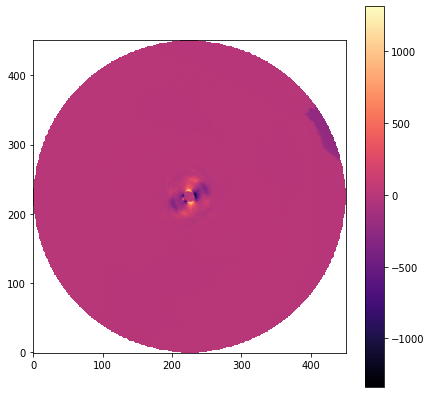

In [5]:
ha.show_result(0)

In [6]:
# ha off
off = diskDuster(offdata_latest, 'test2', 'output', klipparams=[ann, mov, KLs])
off.run_KLIP()
off.get_result()

reading data, num files:  152
Total number of tasks for KLIP processing is 1
Begin processing of wv 0.642 with index 0
Aligning and scaling imgs
Wavelength 0.642 with index 0 has finished align and scale. Queuing for KLIP
Closing threadpool
Derotating Images...
Writing Images to directory /Users/wbalmer/diskShapers/diskImaging/output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 152, 1, 451, 451)
KLIP result is saved to: output/test2-KLmodes-all.fits
result dir is output/test2-KLmodes-all.fits


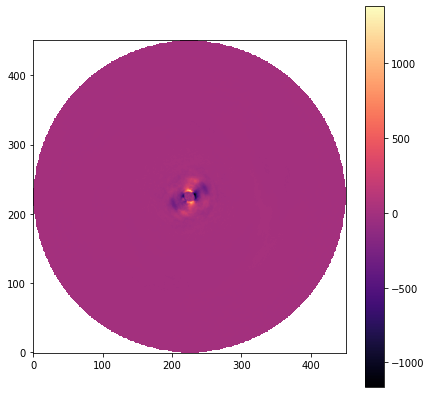

In [7]:
off.show_result(0)

In [8]:
haimg = ha.resultdatacube[0]
offimg = off.resultdatacube[0]

In [4]:
def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius

In [5]:
def domask(img, inn=70, outt=451, fill=np.nan):
    outermask = create_circular_mask(img.shape[0], img.shape[1], radius=outt, leq=True)
    img[~outermask] = fill
    mask = create_circular_mask(img.shape[0], img.shape[1], radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = fill
    return masked_img

In [11]:
n = 70
hamask = domask(haimg, inn=n)
offmask = domask(offimg, inn=n)

In [12]:
summ = hamask + offmask

In [ ]:
# need to place images on same pixel scale 
# gpi = 14.161 ±0.021 mas px−1
# magao = 7.95\pm0.010

In [29]:
platescale=7.95
platescale_err=0.10

def pix2arc(x):
    return (x-225) * platescale


def arc2pix(x):
    return (x / platescale)+225

def negpix2arc(x):
    return -(x-225) * platescale


def negarc2pix(x):
    return -(x / platescale)+225

In [74]:
(350-80)//2

135

In [7]:
plateratio = 7.95/14.161

In [8]:
from skimage.transform import resize

In [9]:
# load in saved hdf5 result
hdf5_filename='/Users/wbalmer/diskShapers/bayesianAstrometry/plottesting.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

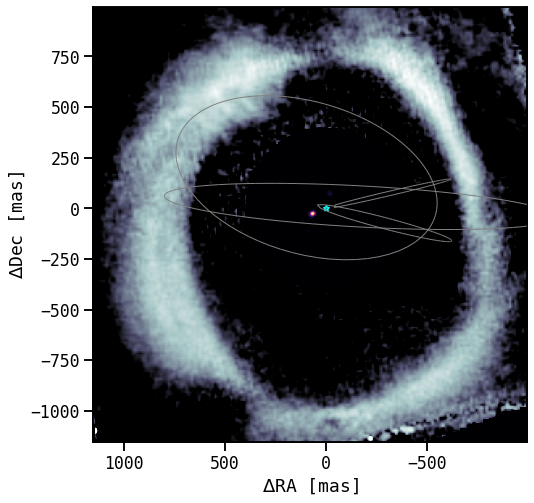

In [97]:
import seaborn as sns
from datetime import datetime
from astropy.time import Time
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'
sns.set_context("talk")

hband_sci, scihead = fits.getdata('S20140425S0255_stokesdc.fits', header=True)
PI = np.sqrt(hband_sci[1]**2 + hband_sci[2]**2)
PI[PI > 3000] = np.nan

PI2 = resize(PI, (451,451))

posSumm = domask(PI2, inn=50, outt=451, fill=np.nan)
# posSumm[posSumm<0] = 0

haimg2 = fits.getdata(root+'/../forwardModel/output/15May15/Ha/doGaussian/Ha4.76-klipped-KLmodes-all.fits')[0]#ha.resultdatacube[0]
offimg2 = fits.getdata(root+'/../forwardModel/output/15May15/Cont/doGaussian/Cont4.792-klipped-KLmodes-all.fits')[0]#off.resultdatacube[0]

n = 6
hamask2 = domask(haimg2, inn=n, outt=19, fill=0)
offmask2 = domask(offimg2, inn=n, outt=19, fill=0)

summ2 = hamask2 + offmask2
# summ2[summ2==np.nan] = 0

# posSumm += summ2
# posSumm[posSumm==np.nan] = 0

from astropy.visualization import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
Anorm = ImageNormalize(stretch=AsinhStretch())
Snorm = ImageNormalize(stretch=SinhStretch())
Lnorm = ImageNormalize(stretch=LogStretch())
from pyklip.klip import nan_gaussian_filter
fig, axs = plt.subplots(1,1, figsize=(8,8), facecolor='white')
inset = axs.imshow(nan_gaussian_filter(summ2, 1), origin='lower', vmin=1, vmax=7, norm=Snorm, cmap='magma', zorder=0)
axs.scatter([225], [225], c='cyan', s=30, marker=(5, 1))


outset = axs.imshow(posSumm, origin='lower', vmin=5, vmax=30, norm=Anorm, cmap='bone', zorder=1)


axs.set_xlim(80,350)
axs.set_ylim(80,350)

axs.tick_params(axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False
                )
axs.tick_params(axis='y',
                which='both',
                left=False,
                right=False,
                labelleft=False
                )
secax = axs.secondary_xaxis('bottom', functions=(negpix2arc, negarc2pix))
secay = axs.secondary_yaxis('left', functions=(pix2arc, arc2pix))
secax.set_xlabel(r'$\Delta$RA [mas]')
secay.set_ylabel(r'$\Delta$Dec [mas]')


# overlay orbits
import astropy.units as u
import astropy.constants as consts
import orbitize.kepler as kepler
from matplotlib.collections import LineCollection
num_orbits_to_plot = 5
object_to_plot = 1
num_epochs_to_plot = 100
start_mjd = 55997.0


data = loaded_results.data
possible_cbar_params = [
    'sma',
    'ecc',
    'inc',
    'aop'
    'pan',
    'tau',
    'plx'
]

# Select random indices for plotted orbit
num_orbits = len(loaded_results.post[:, 0])
if num_orbits_to_plot > num_orbits:
    num_orbits_to_plot = num_orbits
choose = np.random.randint(0, high=num_orbits, size=num_orbits_to_plot)

# Get posteriors from random indices
standard_post = []
# Convert the randomly chosen posteriors to standard keplerian set
for i in np.arange(num_orbits_to_plot):
    orb_ind = choose[i]
    param_set = np.copy(loaded_results.post[orb_ind])
    standard_post.append(loaded_results.basis.to_standard_basis(param_set))


standard_post = np.array(standard_post)

sma = standard_post[:, loaded_results.param_idx['sma{}'.format(object_to_plot)]]
ecc = standard_post[:, loaded_results.param_idx['ecc{}'.format(object_to_plot)]]
inc = standard_post[:, loaded_results.param_idx['inc{}'.format(object_to_plot)]]
aop = standard_post[:, loaded_results.param_idx['aop{}'.format(object_to_plot)]]
pan = standard_post[:, loaded_results.param_idx['pan{}'.format(object_to_plot)]]
tau = standard_post[:, loaded_results.param_idx['tau{}'.format(object_to_plot)]]
plx = standard_post[:, loaded_results.param_idx['plx']]
mtot = standard_post[:, loaded_results.param_idx['mtot']]

raoff = np.zeros((num_orbits_to_plot, num_epochs_to_plot))
deoff = np.zeros((num_orbits_to_plot, num_epochs_to_plot))
vz_star = np.zeros((num_orbits_to_plot, num_epochs_to_plot))
epochs = np.zeros((num_orbits_to_plot, num_epochs_to_plot))


for i in np.arange(num_orbits_to_plot):
    # Compute period (from Kepler's third law)
    period = np.sqrt(4*np.pi**2.0*(sma*u.AU)**3/(consts.G*(mtot*u.Msun)))
    period = period.to(u.day).value

    # Create an epochs array to plot num_epochs_to_plot points over one orbital period
    epochs[i, :] = np.linspace(start_mjd, float(
        start_mjd+period[i]), num_epochs_to_plot)

    # Calculate ra/dec offsets for all epochs of this orbit
    raoff0, deoff0, _ = kepler.calc_orbit(
        epochs[i, :], sma[i], ecc[i], inc[i], aop[i], pan[i],
        tau[i], plx[i], mtot[i], tau_ref_epoch=loaded_results.tau_ref_epoch
    )

    raoff[i, :] = raoff0+225
    deoff[i, :] = deoff0+225

# Plot each orbit (each segment between two points coloured using colormap)
for i in np.arange(num_orbits_to_plot):
    points = np.array([raoff[i, :], deoff[i, :]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(
        segments, colors='grey', linewidth=1.0, zorder=10
    )
    axs.add_collection(lc)

plt.savefig('disk_m'+str(mov)+'.png', dpi=300, transparent=False, bbox_inches="tight")

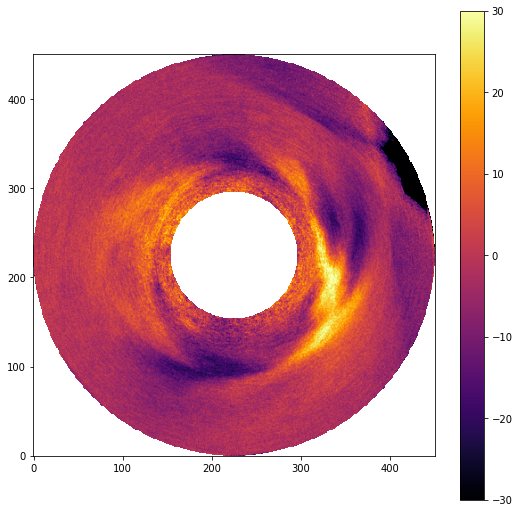

In [14]:
n = 30
plt.figure(figsize=(9,9))
plt.imshow(summ, origin='lower', vmin=-n, vmax=n, cmap='inferno')
plt.colorbar()
plt.savefig('disk_m'+str(mov)+'.png', dpi=200)

In [37]:
# path here
root = os.getcwd()
hadata_latest = root+'/../forwardModel/data/27Apr18/Ha'
offdata_latest = root+'/../forwardModel/data/27Apr18/Cont'
ann = 25
mov = 1
KLs = [25]
# ha
ha = diskDuster(hadata_latest, 'test3', 'output', klipparams=[ann, mov, KLs])
ha.run_KLIP()
ha.get_result()
# ha off
off = diskDuster(offdata_latest, 'test4', 'output', klipparams=[ann, mov, KLs])
off.run_KLIP()
off.get_result()

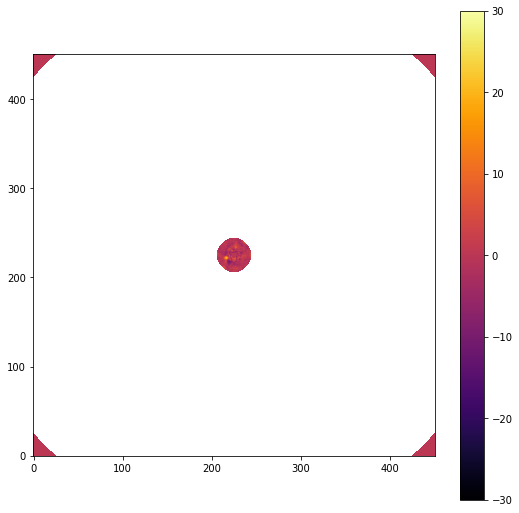

In [54]:
haimg2 = fits.getdata(root+'/../forwardModel/output/15May15/Ha/doGaussian/Ha4.76-klipped-KLmodes-all.fits')[0]#ha.resultdatacube[0]
offimg2 = fits.getdata(root+'/../forwardModel/output/15May15/Cont/doGaussian/Cont4.792-klipped-KLmodes-all.fits')[0]#off.resultdatacube[0]

n = 3
hamask2 = domask(haimg2, inn=n, outt=70)
offmask2 = domask(offimg2, inn=n, outt=70)

summ2 = hamask2 + offmask2

posSumm += summ2

n = 30
plt.figure(figsize=(9,9))
plt.imshow(posSumm, origin='lower', vmin=-n, vmax=n, cmap='inferno')
plt.colorbar()
# plt.savefig('disk_m'+str(mov)+'2.png', dpi=200)

# polarimetry

In [15]:
from astropy.visualization.stretch import AsinhStretch, LogStretch
from astropy.visualization import ImageNormalize

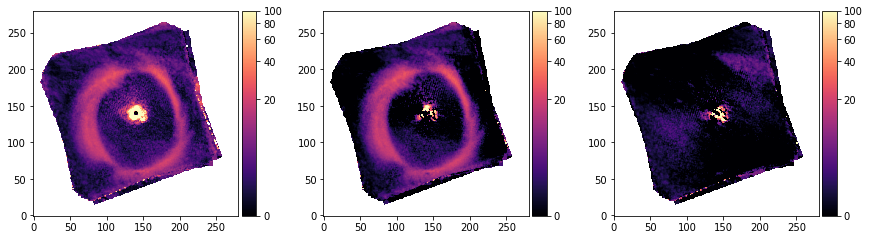

In [16]:
hband_sci, scihead = fits.getdata('S20140425S0255_stokesdc.fits', header=True)
hband_ref, refhead = fits.getdata('S20140425S0288_stokesdc.fits', header=True)
I = hband_sci[0]
Q = hband_sci[1]
U = hband_sci[2]
PI = np.sqrt(hband_sci[1]**2 + hband_sci[2]**2)
PI[PI > 3000] = np.nan

x0, y0 = hband_sci.shape[1]/2, hband_sci.shape[2]/2

def stokes(I, Q, U, x0, y0, theta=0):
    perp = np.zeros_like(I)
    para = np.zeros_like(I)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            phi = np.arctan((i-x0)/(j-y0))+theta
            perp[i,j] = Q[i,j]*np.cos(2*phi) + U[i,j]*np.sin(2*phi)
            para[i,j] = -Q[i,j]*np.sin(2*phi) + U[i,j]*np.cos(2*phi)
    return perp, para

hband_perp, hband_para = stokes(I, Q, U, x0, y0)

from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)
ax_dict = fig.subplot_mosaic(
    [
        ["PI", "Q", "U"],
    ],
)

im1 = ax_dict['PI'].imshow(domask(PI, 4), origin='lower', norm=ImageNormalize(stretch=AsinhStretch(a=0.05), vmin=0, vmax=100), cmap='magma')
divider = make_axes_locatable(ax_dict['PI'])
cax1 = divider.append_axes("right", size="7%", pad=0.05)
cb1 = fig.colorbar(im1, cax=cax1)

im2 = ax_dict['Q'].imshow(domask(hband_perp, 4), origin='lower', norm=ImageNormalize(stretch=AsinhStretch(a=0.05), vmin=0, vmax=100), cmap='magma')
divider = make_axes_locatable(ax_dict['Q'])
cax2 = divider.append_axes("right", size="7%", pad=0.05)
cb2 = fig.colorbar(im2, cax=cax2)

im3 = ax_dict['U'].imshow(domask(hband_para, 4), origin='lower', norm=ImageNormalize(stretch=AsinhStretch(a=0.05), vmin=0, vmax=100), cmap='magma')
divider = make_axes_locatable(ax_dict['U'])
cax3 = divider.append_axes("right", size="7%", pad=0.05)
cb3 = fig.colorbar(im3, cax=cax3)

plt.savefig('GPI-H-disk.png', dpi=300)